# Project 3: Topic Classification using Naive Bayes

**Solution**

# Intro
---
In this project, you'll work with text data from newsgroup posts on a variety of topics. You'll train classifiers to distinguish posts by topics inferred from the text. Whereas with digit classification, where each input is relatively **dense** (represented as a 28x28 matrix of pixels, many of which are non-zero), here each document is relatively **sparse** (represented as a **bag-of-words**). Only a few words of the total vocabulary are active in any given document. The assumption is that a label depends only on the count of words, not their order.

The `sklearn` documentation on feature extraction may be useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on Slack, but <b> please prepare your own write-up with your own code. </b>

## Grading
---
- Make sure to answer every part in every question.
 - There are 7 questions and one extra credit question. 
 - Read carefully what is asked including the notes.
 - Additional points may be deducted if:
   - the code is not clean and well commented, 
   - and if the functions or answers are too long.

 ## Requirements:
---
1. Comment your code.
1. All graphs should have titles, label for each axis, and if needed a legend. It should be understandable on its own.
1. All code must run on colab.research.google.com
1. You should not import any additional libraries.
1. Try and minimize the use of the global namespace (meaning keep things in functions).



In [16]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

import nltk

Load the data, stripping out metadata so that only textual features will be used, and restricting documents to 4 specific topics. By default, newsgroups data is split into training and test sets, but here the test set gets further split into development and test sets.  (If you remove the categories argument from the fetch function calls, you'd get documents from all 20 topics.)

In [17]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test  = fetch_20newsgroups(subset='test',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)

num_test = int(len(newsgroups_test.target) / 2)
test_data, test_labels   = newsgroups_test.data[num_test:], newsgroups_test.target[num_test:]
dev_data, dev_labels     = newsgroups_test.data[:num_test], newsgroups_test.target[:num_test]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print('training label shape:', train_labels.shape)
print('dev label shape:',      dev_labels.shape)
print('test label shape:',     test_labels.shape)
print('labels names:',         newsgroups_train.target_names)

training label shape: (2034,)
dev label shape: (676,)
test label shape: (677,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


### Question 1: Examining your data
---

 1. For each of the first 5 training examples, print the text of the message along with the label (checkout newsgroups_train.target_names).

In [3]:
def Q1(num_examples=5):
    ### STUDENT START ###
    
    # printing text of the message along with the label
    num_examples
    for i in range(num_examples):
        print('message:')
        print(train_data[i])
        print()
        print('label:')
        print(newsgroups_train.target_names[train_labels[i]])
        print()
        print('='*80)
        print()
    ### STUDENT END ###

Q1(5)

message:
Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych

label:
comp.graphics


message:


Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil corruption
for centuries.

label:
talk.religi

### Question 2: Text representation
---

1. Transform the training data into a matrix of **word** unigram feature vectors.
  1. What is the size of the vocabulary? 
  1. What is the average number of non-zero features per example?  
  1. What is the fraction of the non-zero entries in the matrix?  
  1. What are the 0th and last feature strings (in alphabetical order)?
  - _Use `CountVectorization` and its `.fit_transform` method.  Use `.nnz` and `.shape` attributes, and `.get_feature_names` method._
1. Now transform the training data into a matrix of **word** unigram feature vectors restricting to the vocabulary with these 4 words: ["atheism", "graphics", "space", "religion"].  Confirm the size of the vocabulary. 
  1. What is the average number of non-zero features per example?
  - _Use `CountVectorization(vocabulary=...)` and its `.transform` method._
1. Now transform the training data into a matrix of **character** bigram and trigram feature vectors.  
  1. What is the size of the vocabulary?
  - _Use `CountVectorization(analyzer=..., ngram_range=...)` and its `.fit_transform` method._
1. Now transform the training data into a matrix of **word** unigram feature vectors and prune words that appear in fewer than 10 documents.  
  1. What is the size of the vocabulary?<br/>
  - _Use `CountVectorization(min_df=...)` and its `.fit_transform` method._
1. Now again transform the training data into a matrix of **word** unigram feature vectors. 
 1. What is the fraction of words in the development vocabulary that is missing from the training vocabulary?
 - _Hint: Build vocabularies for both train and dev and look at the size of the difference._

Notes:
* `.fit_transform` makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").
* `.fit_transform` and `.transform` return sparse matrix objects.  See about them at http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. 

In [4]:
def Q2():
    ### STUDENT START ###
    
    # training data into a matrix of word unigram feature vectors
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(train_data)
    print('1.')
    print('Vocabulary Size:',len(vectorizer.get_feature_names()))
    print('Average number of non-zero features',X.nnz/len(train_data))
    print('Fraction of non-zero entries:',X.nnz/(X.shape[0]*X.shape[1]))
    print('0th feature string:',vectorizer.get_feature_names()[0])
    print('Last feature string:',vectorizer.get_feature_names()[-1])
    print()
    
    # training data into a matrix of word unigram feature vectors restricting to the vocabulary 
    # with these 4 words: ["atheism", "graphics", "space", "religion"]
    vectorizer = CountVectorizer(vocabulary = ["atheism", "graphics", "space", "religion"])
    X = vectorizer.transform(train_data)
    print('2.')
    print('Vocabulary Size:',len(vectorizer.get_feature_names()))
    print('Average number of non-zero features',X.nnz/len(train_data))
    print()
    
    # training data into a matrix of character bigram and trigram feature vectors
    vectorizer = CountVectorizer(analyzer='char', ngram_range=(2, 3))
    X = vectorizer.fit_transform(train_data)
    print('3.')
    print('Vocabulary Size:',len(vectorizer.get_feature_names()))
    print()
    
    # transform the training data into a matrix of word unigram feature vectors and prune words 
    vectorizer = CountVectorizer(min_df=10)
    X = vectorizer.fit_transform(train_data)
    print('4.')
    print('Vocabulary Size:',len(vectorizer.get_feature_names()))
    print()
    
    # compare dev vocab to train vocab
    vectorizer_train = CountVectorizer()
    vectorizer_dev = CountVectorizer()
    X_train = vectorizer_train.fit_transform(train_data)
    X_dev = vectorizer_dev.fit_transform(dev_data)  
    # use sets in order to do subtraction (essentially set of items in a not in b)
    dev_not_in_train = list(set(vectorizer_dev.get_feature_names()) - set(vectorizer_train.get_feature_names()))
    print('5.')
    print('Fraction of words in the development vocabulary that are missing from the training vocabulary:',len(dev_not_in_train)/len(vectorizer_dev.get_feature_names()))
    print()
    
    ### STUDENT END ###

Q2()

1.
Vocabulary Size: 26879
Average number of non-zero features 96.70599803343165
Fraction of non-zero entries: 0.0035978272269590263
0th feature string: 00
Last feature string: zyxel

2.
Vocabulary Size: 4
Average number of non-zero features 0.26843657817109146

3.
Vocabulary Size: 35478

4.
Vocabulary Size: 3064

5.
Fraction of words in the development vocabulary that are missing from the training vocabulary: 0.24787640034470024



### Question 3: Initial model evaluation
---

1. Transform the training and development data to matrices of word unigram feature vectors.
1. Produce several k-Nearest Neigbors models by varying k, including one with k set to optimize f1 score.  For each model, show the k value and f1 score. 
1. Produce several Naive Bayes models by varying smoothing (alpha), including one with alpha set approximately to optimize f1 score.  For each model, show the alpha value and f1 score.
1. Produce several Logistic Regression models by varying L2 regularization strength (C), including one with C set approximately to optimize f1 score.  For each model, show the C value, f1 score, and sum of squared weights for each topic.
1. Why doesn't k-Nearest Neighbors work well for this problem?
1. Why doesn't Logistic Regression work as well as Naive Bayes does?
1. What is the relationship between logistic regression's sum of squared weights vs. C value?

Notes:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `CountVectorizer` and its `.fit_transform` and `.transform` methods to transform data.
* You can use `KNeighborsClassifier(...)` to produce a k-Nearest Neighbors model.
* You can use `MultinomialNB(...)` to produce a Naive Bayes model.
* You can use `LogisticRegression(C=..., solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* You can use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* You can use `metrics.f1_score(..., average="weighted")` to compute f1 score.

In [5]:
def Q3():
    ### STUDENT START ###
    
    # vectorize train and dev data
    vectorizer = CountVectorizer()
    X_train = vectorizer.fit_transform(train_data)
    X_dev = vectorizer.transform(dev_data)  
    y_train = train_labels
    y_dev = dev_labels
    topics = ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']

    # looping through k for knn 
    print('K-Nearest Neighbors:')
    for k in [1,10,112,200]:
        knn = KNeighborsClassifier(k)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_dev)
        print('    k:',k)
        print('    f1:',round(metrics.f1_score(y_dev, y_pred,average='weighted'),3))
        print()

    # looping through alpha for naive bayes
    print('Multinomial Naive Bayes:')
    for alpha in [0.001,0.01,0.095,1]:
        mnb = MultinomialNB(alpha = alpha)
        mnb.fit(X_train, y_train)
        y_pred = mnb.predict(X_dev)
        print('    alpha:',alpha)
        print('    f1:',round(metrics.f1_score(y_dev, y_pred,average='weighted'),3))
        print()

    # looping through C for logistic regression
    print('Logistic Regression:')
    for C in [0.001,0.01,0.14,0.2,0.5,0.6,0.7,1]:
        lrc = LogisticRegression(C=C, solver="liblinear", multi_class="auto")
        lrc.fit(X_train, y_train)
        y_pred = lrc.predict(X_dev)
        print('    C:',C)
        print('    f1:',round(metrics.f1_score(y_dev, y_pred,average='weighted'),3))
        for topic,coef in zip(topics,lrc.coef_):
            print('    '+topic+' sum of squared weights:',np.sum([i**2 for i in coef]))
        print()
        
        
    ### STUDENT END ###

Q3()

K-Nearest Neighbors:
    k: 1
    f1: 0.381

    k: 10
    f1: 0.428

    k: 112
    f1: 0.479

    k: 200
    f1: 0.418

Multinomial Naive Bayes:
    alpha: 0.001
    f1: 0.77

    alpha: 0.01
    f1: 0.775

    alpha: 0.095
    f1: 0.792

    alpha: 1
    f1: 0.778

Logistic Regression:
    C: 0.001
    f1: 0.619
    alt.atheism sum of squared weights: 0.16509345166829323
    comp.graphics sum of squared weights: 0.20095274690582257
    sci.space sum of squared weights: 0.1806709375439649
    talk.religion.misc sum of squared weights: 0.18724278437849426

    C: 0.01
    f1: 0.665
    alt.atheism sum of squared weights: 2.5414784670795845
    comp.graphics sum of squared weights: 2.9397093683564717
    sci.space sum of squared weights: 2.8624688387630717
    talk.religion.misc sum of squared weights: 2.2500292098346186

    C: 0.14
    f1: 0.71
    alt.atheism sum of squared weights: 36.64134786056576
    comp.graphics sum of squared weights: 32.36662571389845
    sci.space sum of sq

ANSWER: 

Why doesn't k-Nearest Neighbors work well for this problem?
Too many features, scaling. The distance metrics for all the dimensions very performance limiting. KNN is also very sensitive to outliers/noise. Adding more neighbors improves accuracy for that very reason, the extra neighbors help to balance against outliers/noisy data but we quickly hit a maximum and more neighbors doesn't improve accuracy and the added calculation time just hurts performance. 

Why doesn't Logistic Regression work as well as Naive Bayes does?
Logistic Regression is prone to overfitting with a great deal of features. It is also difficult to fit to complex relationships as is the case here with text based topic classification.  


What is the relationship between logistic regression's sum of squared weights vs. C value?
The greater the C values the greater the sum of squared weights.


### Question 4: Feature exploration
---

1. Transform the data to a matrix of word **bigram** feature vectors.  Produce a Logistic Regression model.
1. For each topic, find the 5 features with the largest weights (not absolute value). If there are no overlaps, you can expect 20 features in total.
1. Show a 20 row (features) x 4 column (topics) table of the weights. So, for each of the features (words) found, we show their weight for all topics.
1. Do you see any surprising features in this table?

Notes:
* Train on the transformed training data.
* You can use `CountVectorizer` and its `.fit_transform` method to transform data.
* You can use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* You can use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* You can use `np.argsort` to get indices sorted by element value. 


In [6]:
def Q4():
    ### STUDENT START ###

    # vectorize data 
    vectorizer = CountVectorizer(analyzer='word', ngram_range=(2, 2))
    X_train = vectorizer.fit_transform(train_data)
    X_dev = vectorizer.transform(dev_data)  
    y_train = train_labels
    y_dev = dev_labels
    topics = ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']

    # train logistic regression classifier
    lrc = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")
    lrc.fit(X_train, y_train)

    # gather top features and indicies of each topic
    features = []
    indicies=[]
    for topic,coef in zip(topics,lrc.coef_):
        for i in np.argsort(coef)[::-1][:5]:
            features.append(vectorizer.get_feature_names()[i])
            indicies.append(i)

    # append weights for each feature gathered
    alt_atheism_weights=[]
    comp_graphics_weights=[]
    sci_space_weights=[]
    talk_religion_misc_weights=[]
    for i in indicies:
        alt_atheism_weights.append(lrc.coef_[0][i])
        comp_graphics_weights.append(lrc.coef_[1][i])
        sci_space_weights.append(lrc.coef_[2][i])
        talk_religion_misc_weights.append(lrc.coef_[3][i])

    # write to df
    df = pd.DataFrame(index = features)
    df['alt_atheism_weights'] = alt_atheism_weights
    df['comp_graphics_weights'] = comp_graphics_weights
    df['sci_space_weights'] = sci_space_weights
    df['talk_religion_misc_weights'] = talk_religion_misc_weights

    display(df)
    
    
    ### STUDENT END ###

Q4()

,alt_atheism_weights,comp_graphics_weights,sci_space_weights,talk_religion_misc_weights
claim that,0.605549,-0.199042,-0.274383,-0.140369
cheers kent,0.555719,-0.697903,-0.663776,0.534812
was just,0.482050,-0.131419,-0.128862,-0.227465
you are,0.472741,-0.279913,-0.481426,0.028367
are you,0.446954,-0.248257,-0.097166,-0.305622
looking for,-0.630341,1.108366,-0.499926,-0.571863
in advance,-0.459351,0.832568,-0.438488,-0.418455
comp graphics,-0.292166,0.801202,-0.370919,-0.285185
out there,-0.274802,0.758683,-0.479004,-0.277087
is there,-0.340882,0.754978,-0.468250,-0.257080


ANSWER: A couple of features are surprising. "cheers kent" comes up twice. In the top 5 features (largest coef) for the alt.atheism weights and the talk.religion.misc weights. Also "the fbi" being a top feature for talk.religion.misc is surprising. 

### Question 5: Pre-processing for text
---

To improve generalization, it is common to try preprocessing text in various ways before splitting into words. For example, you could try transforming strings to lower case, replacing sequences of numbers with single tokens, removing various non-letter characters, and shortening long words.

1. Produce a Logistic Regression model (with no preprocessing of text). **Note that you may need to override the "default" preprocessing with an identity function**. Evaluate and show its f1 score and size of the dictionary.
1. Produce an improved Logistic Regression model by preprocessing the text. Evaluate and show its f1 score and size of the vocabulary.  Aim for an improvement in f1 score of 0.02. **Note: this is actually very hard**.
1. How much did the improved model reduce the vocabulary size?

Notes:
* Things you can try: ** ???: Anything else we can suggest** 
 - Look at default pre-processing done.
 - Removing stop words.
 - Experiment with different ways of getting rid of apostrophe's such as replacing them with spaces or with empty strings.
  - Lower casing.
  - Including both lowercase and original case versions of a word.
  - nltk functions such as stemming.
* Train on the "transformed" training data, the data after you applied pre-processing.
* Evaluate on the transformed development data. Note that you never want to "learn" anything from the dev data.
* You can use `CountVectorizer(preprocessor=...)` to preprocess strings with your own custom-defined function.
* `CountVectorizer` default is to preprocess strings to lower case.
* You can use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* You can use `metrics.f1_score(..., average="weighted")` to compute f1 score.
* If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular.
* The order you apply pre-processing may produce different results.


In [7]:
def Q5():
    ### STUDENT START ###

    
    
    # vectorize data no preprocessing
    vectorizer = CountVectorizer(preprocessor=identity)
    X_train = vectorizer.fit_transform(train_data)
    X_dev = vectorizer.transform(dev_data)  
    y_train = train_labels
    y_dev = dev_labels
    topics = ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']

    # train logistic regression classifier
    lrc = LogisticRegression(C=0.6, solver="liblinear", multi_class="auto")
    lrc.fit(X_train, y_train)
    y_pred = lrc.predict(X_dev)
    print('No Preprocessing:')
    print('    Dictionary Size:',len(vectorizer.get_feature_names()))
    print('    f1 Score:',round(metrics.f1_score(y_dev, y_pred,average='weighted'),3))
    
    # vectorize data with preprocessing
    vectorizer = CountVectorizer(preprocessor=preprocessor)
    X_train = vectorizer.fit_transform(train_data)
    X_dev = vectorizer.transform(dev_data)  
    y_train = train_labels
    y_dev = dev_labels
    topics = ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']

    # train logistic regression classifier
    lrc = LogisticRegression(C=0.6, solver="liblinear", multi_class="auto")
    lrc.fit(X_train, y_train)
    y_pred = lrc.predict(X_dev)
    print('With Preprocessing:')
    print('    Dictionary Size:',len(vectorizer.get_feature_names()))
    print('    f1 Score:',round(metrics.f1_score(y_dev, y_pred,average='weighted'),3))
    
def identity(x):
    return x

def preprocessor(x):
    
    # make x lowercase
    x = x.lower()
    
    # the below code made it worse :( sometimes lowercase is all you need...
    
#     # remove possessive apostrophes
#     if "'s" in x:
#         x = x.replace("'s", "")
#     # remove all apostrophies
#     elif "'" in x:
#         x = x.replace("'","")
    
#     # remove special characters
#     for char in x:
#         if char not in '0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ':
#             x = x.replace('char','')
    
#     # replace all number sequences with 'NUMBERSEQUENCETOKEN'
#     if set(x)-set('abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ')==set(x):
#             x = 'NUMBERSEQUENCETOKEN'
            
    return x
    
    ### STUDENT END ###

Q5()

No Preprocessing:
    Dictionary Size: 33291
    f1 Score: 0.704
With Preprocessing:
    Dictionary Size: 26879
    f1 Score: 0.711


### Question 6: L1 and L2 regularization
---

The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. Logistic regression seeks the set of weights that minimizes errors in the training data AND has a small total size. The default L2 regularization computes this size as the sum of the squared weights (as in Part 3 above). L1 regularization computes this size as the sum of the absolute values of the weights. Whereas L2 regularization makes all the weights relatively small, **L1 regularization drives many of the weights to 0, effectively removing unimportant features**. For this reason, we can use it as a way to do "feature selection".

1. For several L1 regularization strengths ...
  1. Produce a Logistic Regression model using the **L1** regularization strength.  Reduce the vocabulary to only those features that have at least one non-zero weight among the four categories.
  1. Produce a new Logistic Regression model using the reduced vocabulary . For this new model, use an **L2** regularization strength of 0.5.  
  1. Evaluate and show the L1 regularization strength, vocabulary size, and f1 score associated with the new model.
1. Show a plot of f1 score vs. log vocabulary size.  Each point corresponds to a specific L1 regularization strength used to reduce the vocabulary.
1. How does performance of the models based on reduced vocabularies compare to that of a model based on the full vocabulary?

Notes:
* No need to apply pre-processing from question 5.
* Train on the transformed (i.e. CountVectorizer) training data.
* Evaluate on the transformed development data (using the CountVectorizer instance you trained on the training data).
* You can use `LogisticRegression(..., penalty="l1")` to produce a logistic regression model using L1 regularization.
* You can use `LogisticRegression(..., penalty="l2")` to produce a logistic regression model using L2 regularization.
* You can use `LogisticRegression(..., tol=0.015)` to produce a logistic regression model using relaxed gradient descent convergence criteria.  The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.015 (the default is .0001).
* (solver="liblinear" might be needed for it not to crash)

Logistic Regression for several L1 regularization strengths:


/Users/Iris/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


    C: 2
    Vocabulary Size: 1944
    f1 Score: 0.684

    C: 1
    Vocabulary Size: 962
    f1 Score: 0.687

    C: 0.5
    Vocabulary Size: 697
    f1 Score: 0.682

    C: 0.2
    Vocabulary Size: 364
    f1 Score: 0.678

    C: 0.14
    Vocabulary Size: 276
    f1 Score: 0.688

    C: 0.01
    Vocabulary Size: 16
    f1 Score: 0.462

    C: 0.001
    Vocabulary Size: 2
    f1 Score: 0.323



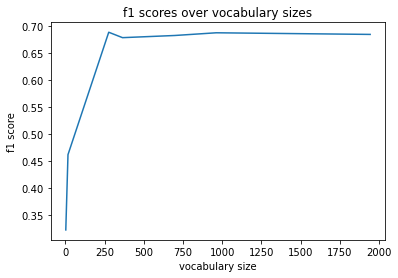

In [8]:
def Q6():
    # Keep this random seed here to make comparison easier.
    np.random.seed(0)

    ### STUDENT START ###
    
    print('Logistic Regression for several L1 regularization strengths:')
    vocab_sizes = []
    f1s = []

    for C in [0.001,0.01,0.14,0.2,0.5,1,2][::-1]:

        # vectorize data 
        vectorizer = CountVectorizer()
        X_train = vectorizer.fit_transform(train_data)
        X_dev = vectorizer.transform(dev_data)  
        y_train = train_labels
        y_dev = dev_labels
        topics = ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']

        # train logistic regression classifier
        lrc = LogisticRegression(C=C, solver="liblinear", multi_class="auto", penalty="l1")
        lrc.fit(X_train, y_train)
        y_pred = lrc.predict(X_dev)

        # list comprehension for all indicies for nonzero features
        indicies = list(set([i for i,j in zip(set(list(np.argsort(lrc.coef_[0]))+list(np.argsort(lrc.coef_[1]))+list(np.argsort(lrc.coef_[2]))+list(np.argsort(lrc.coef_[3]))),lrc.coef_[0]+lrc.coef_[1]+lrc.coef_[2]+lrc.coef_[3]) if j!=0]))
        vocabulary = [vectorizer.get_feature_names()[i] for i in indicies]


        # vectorize data 
        vectorizer = CountVectorizer(vocabulary = vocabulary)
        X_train = vectorizer.fit_transform(train_data)
        X_dev = vectorizer.transform(dev_data)  
        y_train = train_labels
        y_dev = dev_labels
        topics = ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']

        # train logistic regression classifier
        lrc = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto", penalty="l2")
        lrc.fit(X_train, y_train)
        y_pred = lrc.predict(X_dev)

        # print vocab size and f1 and append lists for plots
        vocab_size = len(vectorizer.get_feature_names())
        f1 = round(metrics.f1_score(y_dev, y_pred,average='weighted'),3)
        print('    C:',C)
        print('    Vocabulary Size:',vocab_size)
        print('    f1 Score:',f1)
        print()
        f1s.append(f1)
        vocab_sizes.append(vocab_size)

    # plot using vocab sizes and f1s lists
    plt.plot(vocab_sizes,f1s)
    plt.title('f1 scores over vocabulary sizes')
    plt.xlabel('vocabulary size')
    plt.ylabel('f1 score')
    plt.show()


    

    ### STUDENT END ###

Q6()

ANSWER: 

How does performance of the models based on reduced vocabularies compare to that of a model based on the full vocabulary?

They are overall worse models, especially with significantly reduced vocabularies.

### Question 7: TfIdf
---
As you may recall [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) stands for *term frequency inverse document frequency* and is a way to assign a weight to each word or token signifying their importance for a document in a corpus (a collection of documents).

Produce a Logistic Regression model based on data represented in tf-idf form, with L2 regularization strength of 100.  Evaluate and show the f1 score.  How is `TfidfVectorizer` different than `CountVectorizer`?

1. How is `TfidfVectorizer` different than `CountVectorizer`?
1. Show the 3 documents with highest R ratio, where ...
  - $R\,ratio = maximum\,predicted\,probability \div predicted\,probability\,of\,correct\,label$
1. Explain what the R ratio describes.
1. What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

Note:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `TfidfVectorizer` and its `.fit_transform` method to transform data to tf-idf form.
* You can use `LogisticRegression(C=100, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* You can use `LogisticRegression`'s `.predict_proba` method to access predicted probabilities.

In [9]:
def Q7():
    ### STUDENT START ###
    
    
    # vectorize data with TfidfVectorizer
    vectorizer = TfidfVectorizer()
    X_train = vectorizer.fit_transform(train_data)
    X_dev = vectorizer.transform(dev_data)  
    y_train = train_labels
    y_dev = dev_labels
    topics = ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']

    print('Using TfidfVectorizer:')
    # train logistic regression classifier
    lrc = LogisticRegression(C=100, solver="liblinear", multi_class="auto")
    lrc.fit(X_train, y_train)
    y_pred = lrc.predict(X_dev)
    print('    Dictionary Size:',len(vectorizer.get_feature_names()))
    print('    f1 Score:',round(metrics.f1_score(y_dev, y_pred,average='weighted'),3))

    R_ratios = [lrc.predict_proba(X_train)[i].max()/lrc.predict_proba(X_train)[i][y_train[i]] for i in range(len(y_train))]
    indicies = np.argsort(R_ratios)[::-1]

    print('Documents with highest R ratio:')
    print('    1.',train_data[indicies[0]])
    print('    2.',train_data[indicies[1]])
    print('    3.',train_data[indicies[2]])
    
    ### STUDENT END ###

Q7()

Using TfidfVectorizer:
    Dictionary Size: 26879
    f1 Score: 0.76
Documents with highest R ratio:
    1. 
    2. 
    3. 


ANSWER: 

R ratio represents the documents the documents the classifier is most mistaken about.
The 3 documents with the highest R ratio are all empty or contain nothing else but white space.
I would recommend removing the empty documents from the dataset. This way it wouldn't have to evaluate documents which contain no information, thus misleading our logistic regression classifier.

### Question 8 EXTRA CREDIT:
---
Produce a Logistic Regression model to implement your suggestion from Part 7.

In [22]:
def Q8():
    
    ### STUDENT START ###

    clean_data=[]
    clean_labels=[]
    for i,j in zip(train_data,train_labels):
        if i.strip()=='':
            pass
        else:
            clean_data.append(i)
            clean_labels.append(j)
    train_data_ = clean_data
    train_labels_ = np.array(clean_labels)

    clean_data=[]
    clean_labels=[]
    for i,j in zip(dev_data,dev_labels):
        if i.strip()=='':
            pass
        else:
            clean_data.append(i)
            clean_labels.append(j)
    dev_data_ = clean_data
    dev_labels_ = np.array(clean_labels)

    # vectorize data with TfidfVectorizer
    vectorizer = TfidfVectorizer()
    X_train = vectorizer.fit_transform(train_data_)
    X_dev = vectorizer.transform(dev_data_)  
    y_train = train_labels_
    y_dev = dev_labels_
    topics = ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']

    print('Using TfidfVectorizer:')
    # train logistic regression classifier
    lrc = LogisticRegression(C=100, solver="liblinear", multi_class="auto")
    lrc.fit(X_train, y_train)
    y_pred = lrc.predict(X_dev)
    print('    Dictionary Size:',len(vectorizer.get_feature_names()))
    print('    f1 Score:',round(metrics.f1_score(y_dev, y_pred,average='weighted'),3))

    R_ratios = [lrc.predict_proba(X_train)[i].max()/lrc.predict_proba(X_train)[i][y_train[i]] for i in range(len(y_train))]
    indicies = np.argsort(R_ratios)[::-1]
    # printing the documents with highest R ratio again, after improvements were made
    print('Documents with highest R ratio:')
    print('    1. ','Label: ',topics[train_labels_[indicies[0]]])
    print(train_data_[indicies[0]])
    print()
    print('='*80)
    print()
    print('    2.','Label: ',topics[train_labels_[indicies[1]]])
    print(train_data_[indicies[1]])
    print()
    print('='*80)
    print()
    print('    3.','Label: ',topics[train_labels_[indicies[2]]])
    print(train_data_[indicies[2]])
    print()
    print('='*80)
    print()

Q8()

Using TfidfVectorizer:
    Dictionary Size: 26879
    f1 Score: 0.767
Documents with highest R ratio:
    1.  Label:  alt.atheism


This is becoming a tiresome statement.  Coming from you it is 
a definition, not an assertion:

   Islam is good.  Belief in Islam is good.  Therefore, being a 
   believer in Islam can produce only good...because Islam is
   good. Blah blah blah.

That's about as circular as it gets, and equally meaningless.  To
say that something produces only good because it is only good that 
it produces is nothing more than an unapplied definition.  And
all you're application is saying that it's true if you really 
believe it's true.  That's silly.

Conversely, you say off-handedly that _anything_ can happen under
atheism.  Again, just an offshoot of believe-it-and-it-becomes-true-
don't-believe-it-and-it-doesn't.  

Like other religions I'm aquainted with, Islam teaches exclusion and
caste, and suggests harsh penalties for _behaviors_ that have no
logical call for pu